# Credit Card Fraud Detection Using Autoencoder

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива?

### Автокодировщик

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg?w=638&ssl=1" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции.

Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков (30 признаков).

## Declare required dependencies

In [151]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fire"]

## Data ingestion

In [152]:
df = pd.read_csv('smoke_detection_iot.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('UTC', axis=1)
df = df.drop('CNT', axis=1)

## Data exploration

In [153]:
df.head(10)

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.00,0.0,0.000,0.00,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.00,0.0,0.000,0.00,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.00,0.0,0.000,0.00,0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.00,0.0,0.000,0.00,0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.00,0.0,0.000,0.00,0
5,20.073,54.12,0,400,12419,18998,939.725,0.0,0.00,0.0,0.000,0.00,0
6,20.088,53.61,0,400,12432,19058,939.738,0.0,0.00,0.0,0.000,0.00,0
7,20.103,53.20,0,400,12439,19114,939.758,0.0,0.00,0.0,0.000,0.00,0
8,20.117,52.81,0,400,12448,19155,939.758,0.0,0.00,0.0,0.000,0.00,0
9,20.132,52.46,0,400,12453,19195,939.756,0.9,3.78,0.0,4.369,2.78,0


In [154]:
print(df.shape)
print(df.describe())

(62630, 13)
       Temperature[C]   Humidity[%]     TVOC[ppb]     eCO2[ppm]        Raw H2  \
count    62630.000000  62630.000000  62630.000000  62630.000000  62630.000000   
mean        15.970424     48.539499   1942.057528    670.021044  12942.453936   
std         14.359576      8.865367   7811.589055   1905.885439    272.464305   
min        -22.010000     10.740000      0.000000    400.000000  10668.000000   
25%         10.994250     47.530000    130.000000    400.000000  12830.000000   
50%         20.130000     50.150000    981.000000    400.000000  12924.000000   
75%         25.409500     53.240000   1189.000000    438.000000  13109.000000   
max         59.930000     75.200000  60000.000000  60000.000000  13803.000000   

        Raw Ethanol  Pressure[hPa]         PM1.0         PM2.5         NC0.5  \
count  62630.000000   62630.000000  62630.000000  62630.000000  62630.000000   
mean   19754.257912     938.627649    100.594309    184.467770    491.463608   
std      609.51315

## Ести ли пропуски?

In [155]:
df.isnull().values.any()

False

## Class distribution ( 0 - clear, 1 - fire)

In [156]:
df['Fire Alarm'].value_counts()

,count
Fire Alarm,
1,44757
0,17873


<ipython-input-157-3e52f028cfa4>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Fire Alarm'], sort = True)


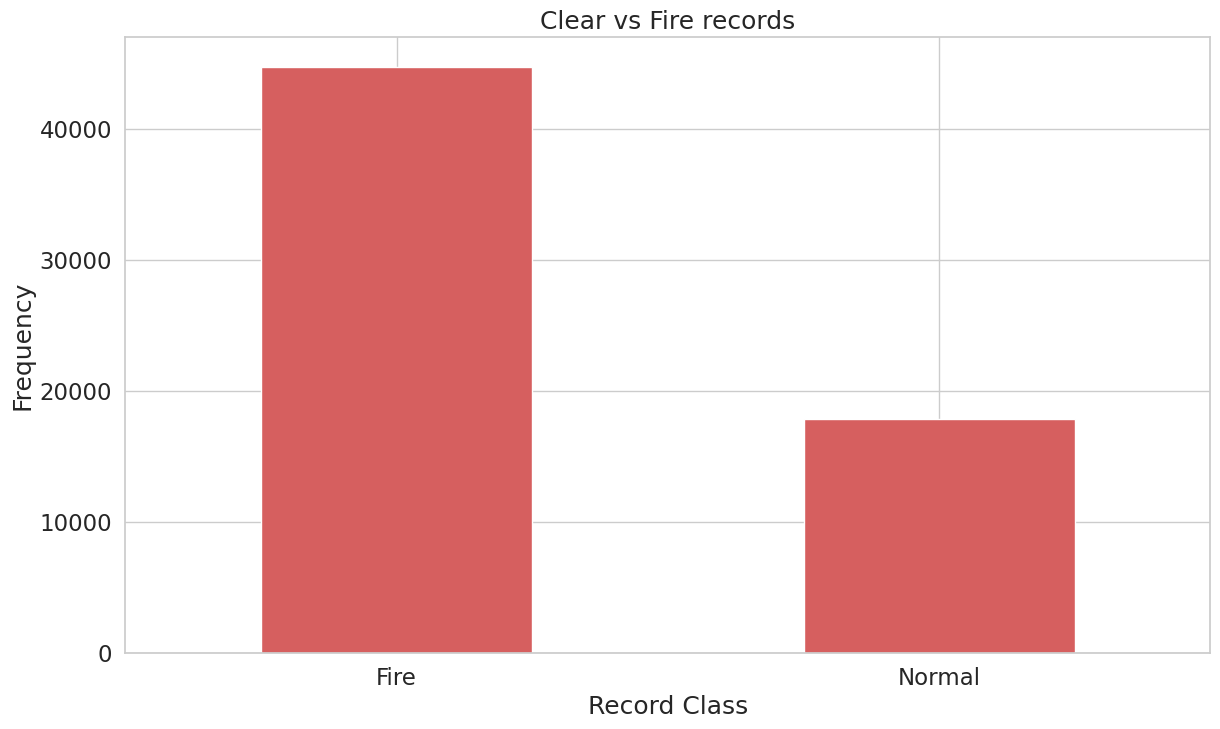

In [157]:
count_classes = pd.value_counts(df['Fire Alarm'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="r")
plt.title("Clear vs Fire records")
plt.xticks(range(2), LABELS[::-1])
plt.xlabel("Record Class")
plt.ylabel("Frequency");

Наш набор данных очень сильно несбалансирован в пользу отрицательного (0, то есть нормального) класса. Это требует дальнейшего изучения данных

In [158]:
fireDF = df[df['Fire Alarm'] == 1]
clearDF = df[df['Fire Alarm'] == 0]

In [159]:
fireDF.shape

(44757, 13)

In [160]:
clearDF.shape

(17873, 13)

## Preprocessing

Также давайте стандартизируем Amount.

In [161]:
df.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0


In [162]:
scaler = StandardScaler()
cols_for_scaler = ['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]',
                     'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']
df[cols_for_scaler] = scaler.fit_transform(df[cols_for_scaler])

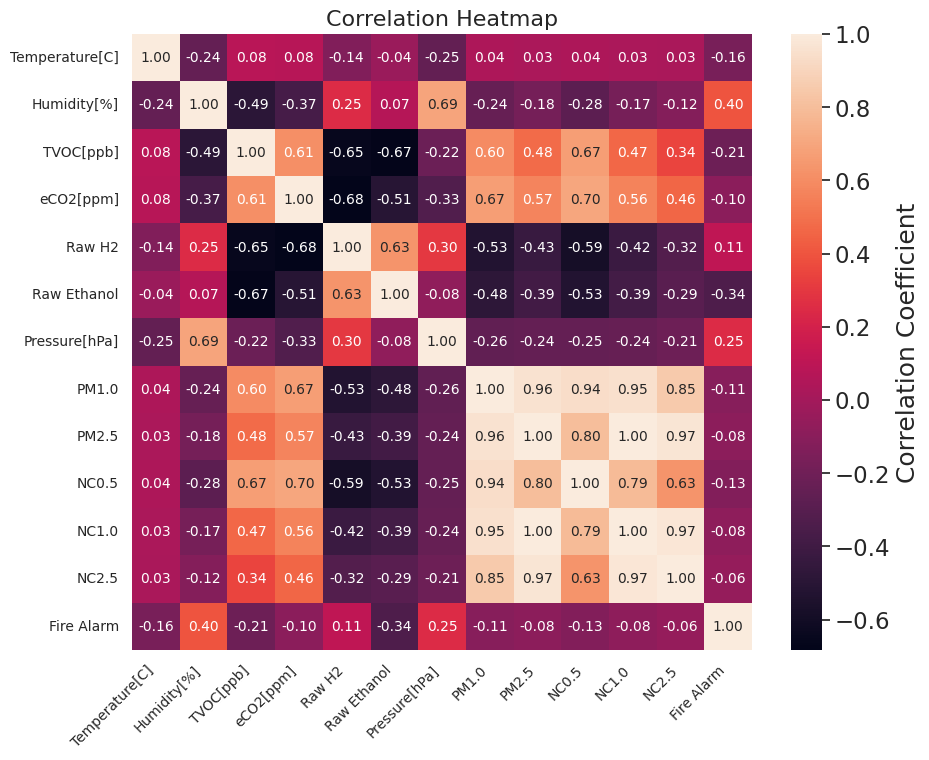

In [163]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f",
            cbar_kws={'label': 'Correlation Coefficient'},
            annot_kws={"size": 10})
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [164]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Fire Alarm'] == 0]
non_fraud_df = df.loc[df['Fire Alarm'] == 1][:17873] # берем последние 492 транзакции

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Перемешивание строк датасета
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
61318,0.316347,-2.993639,1.495603,-0.055104,-0.798107,-1.091467,-1.265386,-0.108057,-0.092865,-0.113752,-0.091484,-0.073868,0
2724,-0.070645,-0.140943,-0.237733,-0.141679,0.930574,0.550841,0.752141,-0.107775,-0.092723,-0.113323,-0.091356,-0.073863,0
14082,0.094124,0.408390,-0.106901,-0.092882,-0.346668,-0.507389,0.199312,-0.107060,-0.092379,-0.112261,-0.091037,-0.073848,1
14697,-0.112777,0.542622,-0.095379,-0.103901,-0.324647,-0.536921,0.185792,-0.107222,-0.092455,-0.112498,-0.091108,-0.073851,1
54056,0.871173,-0.598908,-0.227364,-0.134858,-0.621936,1.317032,-0.923623,-0.107157,-0.092425,-0.112406,-0.091081,-0.073850,0


Распределение классов в подвыборке


,proportion
Fire Alarm,
0,0.5
1,0.5


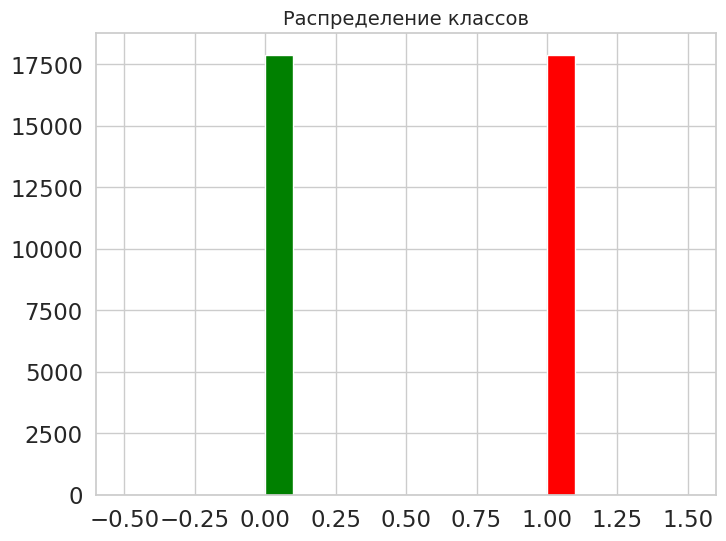

In [165]:
print('Распределение классов в подвыборке')


plt.figure(figsize=(8, 6))
plt.hist(new_df[new_df['Fire Alarm'] == 0]['Fire Alarm'], color='green')
plt.hist(new_df[new_df['Fire Alarm'] == 1]['Fire Alarm'], color='red')

plt.title('Распределение классов', fontsize=14)

new_df['Fire Alarm'].value_counts(normalize=True)

In [166]:
new_df.head(10)

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
61318,0.316347,-2.993639,1.495603,-0.055104,-0.798107,-1.091467,-1.265386,-0.108057,-0.092865,-0.113752,-0.091484,-0.073868,0
2724,-0.070645,-0.140943,-0.237733,-0.141679,0.930574,0.550841,0.752141,-0.107775,-0.092723,-0.113323,-0.091356,-0.073863,0
14082,0.094124,0.408390,-0.106901,-0.092882,-0.346668,-0.507389,0.199312,-0.107060,-0.092379,-0.112261,-0.091037,-0.073848,1
14697,-0.112777,0.542622,-0.095379,-0.103901,-0.324647,-0.536921,0.185792,-0.107222,-0.092455,-0.112498,-0.091108,-0.073851,1
54056,0.871173,-0.598908,-0.227364,-0.134858,-0.621936,1.317032,-0.923623,-0.107157,-0.092425,-0.112406,-0.091081,-0.073850,0
57561,-0.250805,-0.217646,-0.239269,-0.112296,-0.566882,1.533600,-0.847759,-0.106572,-0.092141,-0.111532,-0.090818,-0.073838,0
29530,0.317531,0.155720,-0.239269,-0.141679,1.070043,0.639437,0.760404,-0.106659,-0.092182,-0.111661,-0.090857,-0.073840,1
26132,-0.012565,0.761452,-0.248614,-0.141679,0.449773,0.347398,0.843028,-0.108686,-0.093168,-0.114690,-0.091766,-0.073881,0
43585,0.598879,0.549389,-0.089491,-0.131185,-0.111773,-0.538562,0.074625,-0.107244,-0.092470,-0.112535,-0.091120,-0.073852,1
15459,-0.263410,0.349735,-0.096787,-0.122790,-0.276934,-0.535281,0.147484,-0.106789,-0.092247,-0.111855,-0.090915,-0.073842,1


### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только обычные транзакции, а в тестовом наборе данных будут как обычные, так и мошеннические транзакции.

In [167]:
X_train, X_test = train_test_split(new_df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train['Fire Alarm'] == 0]
X_train = X_train.drop(['Fire Alarm'], axis=1)
#print(type(X_train))
y_test = X_test['Fire Alarm']
X_test = X_test.drop(['Fire Alarm'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)
# print(new_df.shape)

# X_train, X_test, y_train, y_test = train_test_split(new_df, new_df['Fire Alarm'], test_size=0.2, random_state=RANDOM_SEED)
# X_train = X_train.values
# #print(type(X_train))
# X_test = X_test.values
# y_test = y_test.values
# print(y_test.size)

# # Предположим, что у вас есть столбец 'label', где указаны классы
# X = new_df.drop('Fire Alarm', axis=1)  # Признаки
# y = new_df['Fire Alarm']  # Метки классов

# # Стратифицированное разделение
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

# # Объедините обратно в DataFrame при необходимости
# train_data = pd.concat([X_train, y_train], axis=1)
# test_data = pd.concat([X_test, y_test], axis=1)



# X = new_df.drop(['Fire Alarm'], axis=1)
# y = new_df['Fire Alarm']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED, stratify=y)
# X_train = X_train.values
# #print(type(X_train))
# X_test = X_test.values
# y_test = y_test.values
# print(y_test.size)



7150


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 14,7,7,29 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 29 узлов, соответствующих 29 функциям в элементе входных данных.

In [168]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(12, 10),
            nn.Tanh(),
            nn.Linear(10, 5),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(5, 5),
           nn.Tanh(),
           nn.Linear(5, 12),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [169]:
model = Autoencoder().double()
#model = Autoencoder().double().cpu()

In [170]:
num_epochs = 100   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [171]:

train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)


In [172]:

#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [174]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)


In [175]:
history = {'train_loss': [], 'test_loss': []}

In [176]:
for epoch in range(num_epochs):
    h = []
    for data in train_loader:
        data = data.double()  # Убедитесь, что данные в правильном формате
        output = model(data)
        loss = criterion(output, data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        h.append(loss.item())

    mean_loss = np.mean(h)
    print(f'epoch [{epoch + 1}/{num_epochs}], loss: {mean_loss:.4f}')
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), 'fire.pth')

epoch [1/100], loss: 1.8564
epoch [2/100], loss: 1.3928
epoch [3/100], loss: 1.1522
epoch [4/100], loss: 1.0226
epoch [5/100], loss: 0.9415
epoch [6/100], loss: 0.8852
epoch [7/100], loss: 0.8455
epoch [8/100], loss: 0.8170
epoch [9/100], loss: 0.7946
epoch [10/100], loss: 0.7733
epoch [11/100], loss: 0.7450
epoch [12/100], loss: 0.7237
epoch [13/100], loss: 0.7064
epoch [14/100], loss: 0.6925
epoch [15/100], loss: 0.6830
epoch [16/100], loss: 0.6739
epoch [17/100], loss: 0.6671
epoch [18/100], loss: 0.6606
epoch [19/100], loss: 0.6551
epoch [20/100], loss: 0.6503
epoch [21/100], loss: 0.6464
epoch [22/100], loss: 0.6414
epoch [23/100], loss: 0.6377
epoch [24/100], loss: 0.6340
epoch [25/100], loss: 0.6311
epoch [26/100], loss: 0.6278
epoch [27/100], loss: 0.6253
epoch [28/100], loss: 0.6221
epoch [29/100], loss: 0.6201
epoch [30/100], loss: 0.6167
epoch [31/100], loss: 0.6145
epoch [32/100], loss: 0.6123
epoch [33/100], loss: 0.6102
epoch [34/100], loss: 0.6073
epoch [35/100], loss: 0

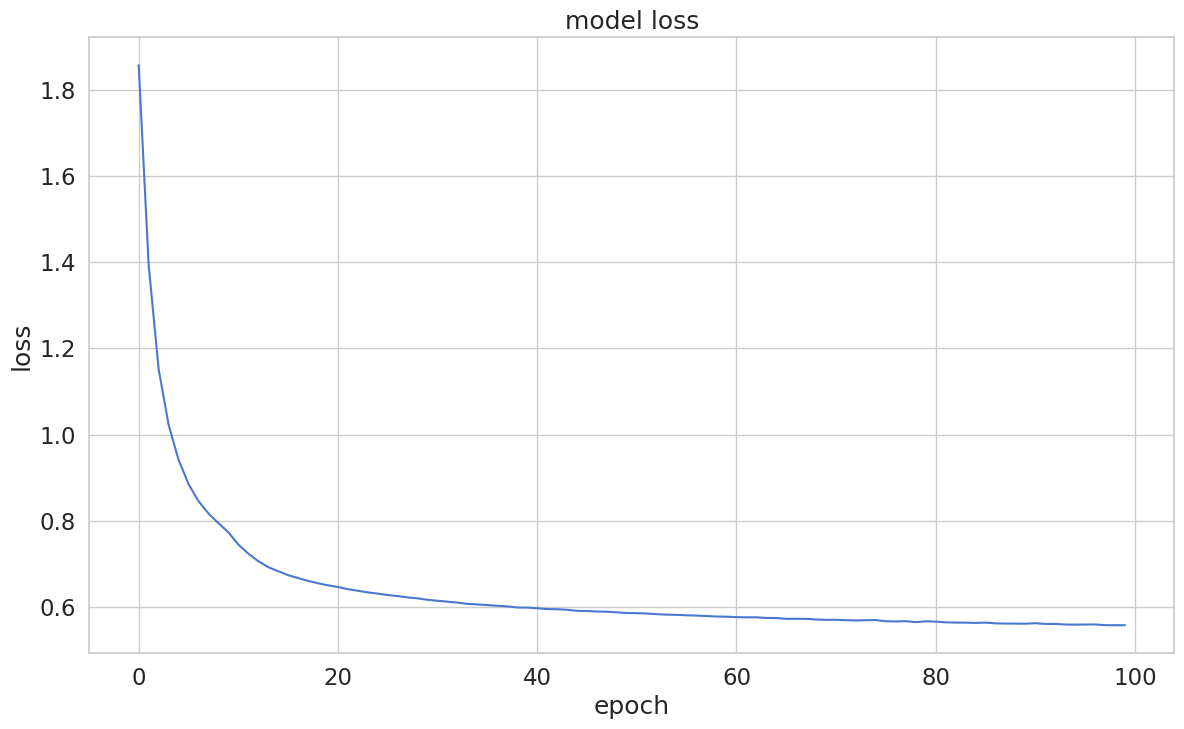

In [177]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Оценка модели

In [178]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Fire Alarm'] = y_test

In [179]:
reconstructionErrorDF.describe()

,pred_loss,Fire Alarm
count,7150.000000,7150.000000
mean,0.615532,0.504615
std,1.672522,0.500014
min,0.005971,0.000000
25%,0.063020,0.000000
50%,0.122048,1.000000
75%,0.481249,1.000000
max,62.837812,1.000000


# Reconstruction Errors without Fraud

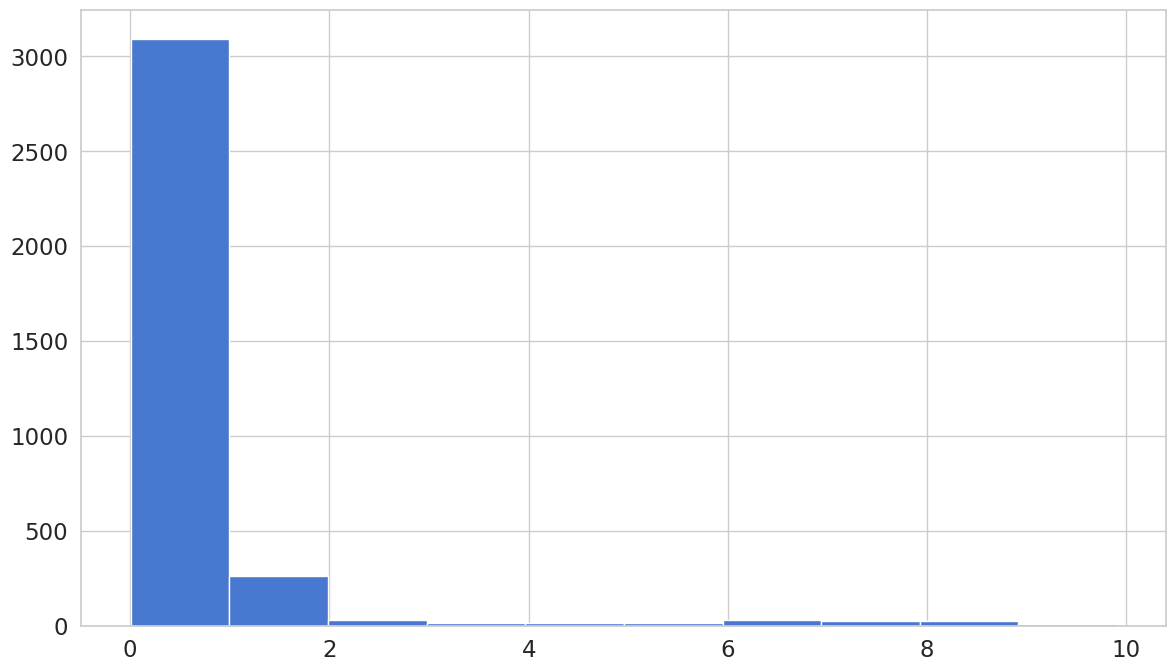

In [180]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Fire Alarm'] == 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with Fraud

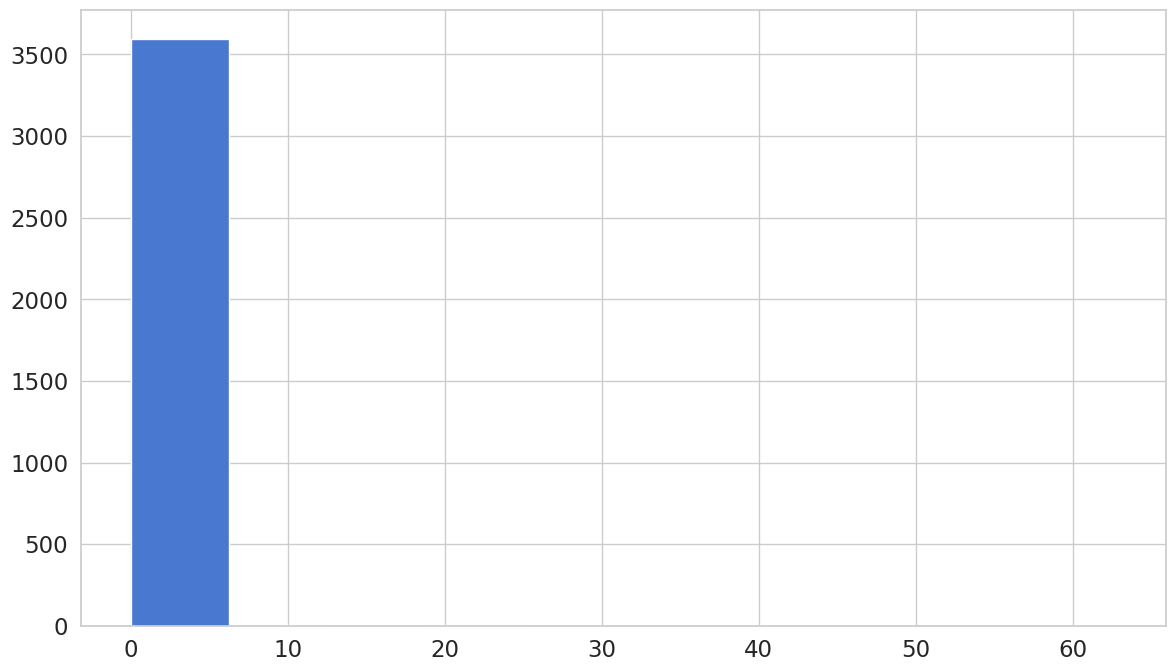

In [181]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Fire Alarm']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

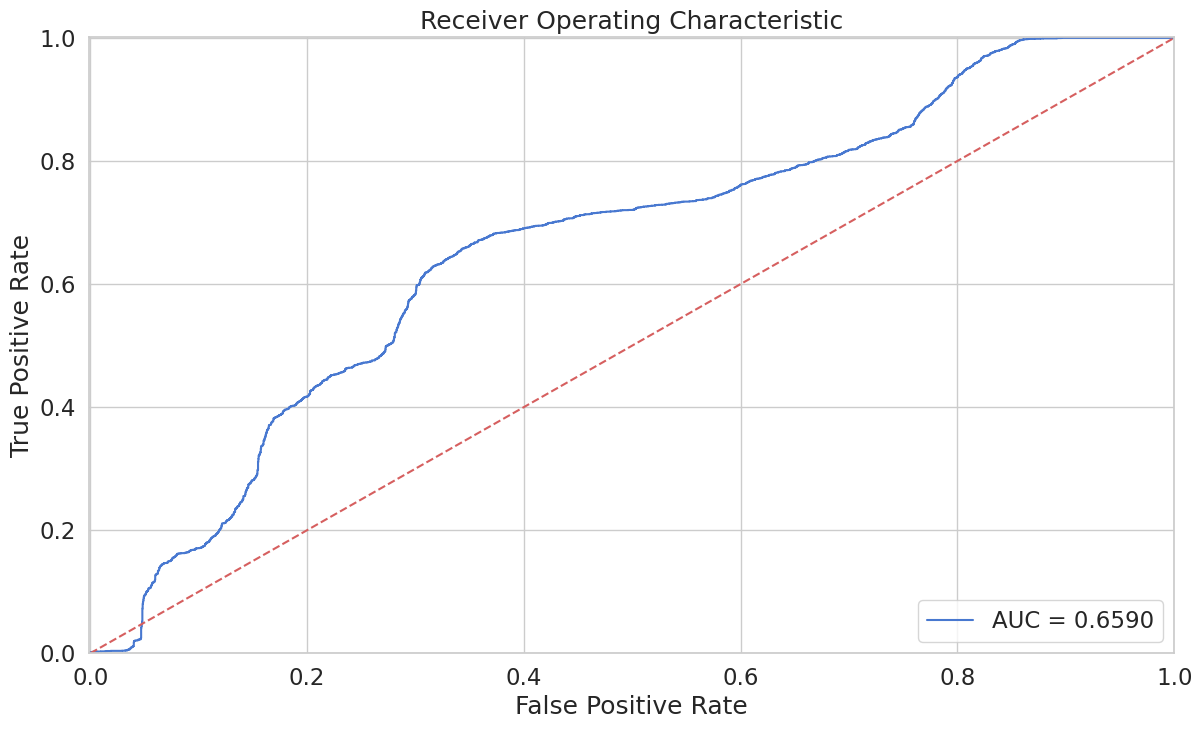

In [182]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF['Fire Alarm'], reconstructionErrorDF['pred_loss'])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

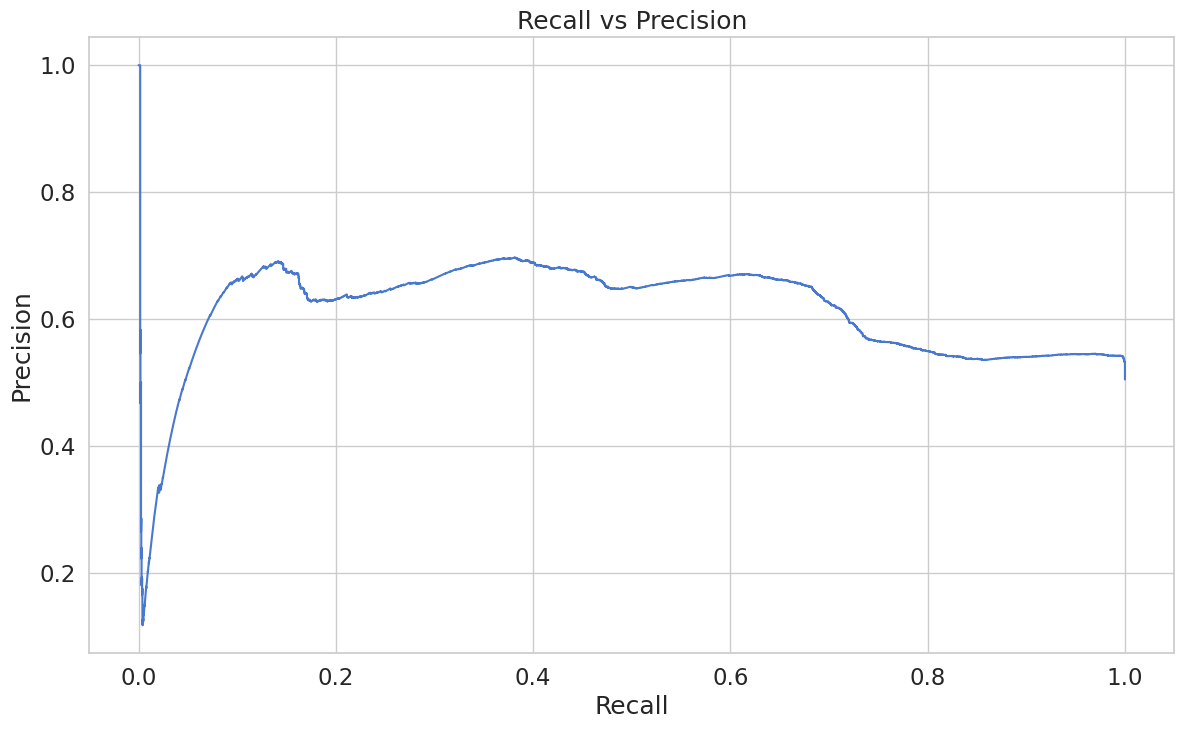

In [183]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF['Fire Alarm'], reconstructionErrorDF['pred_loss'])
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

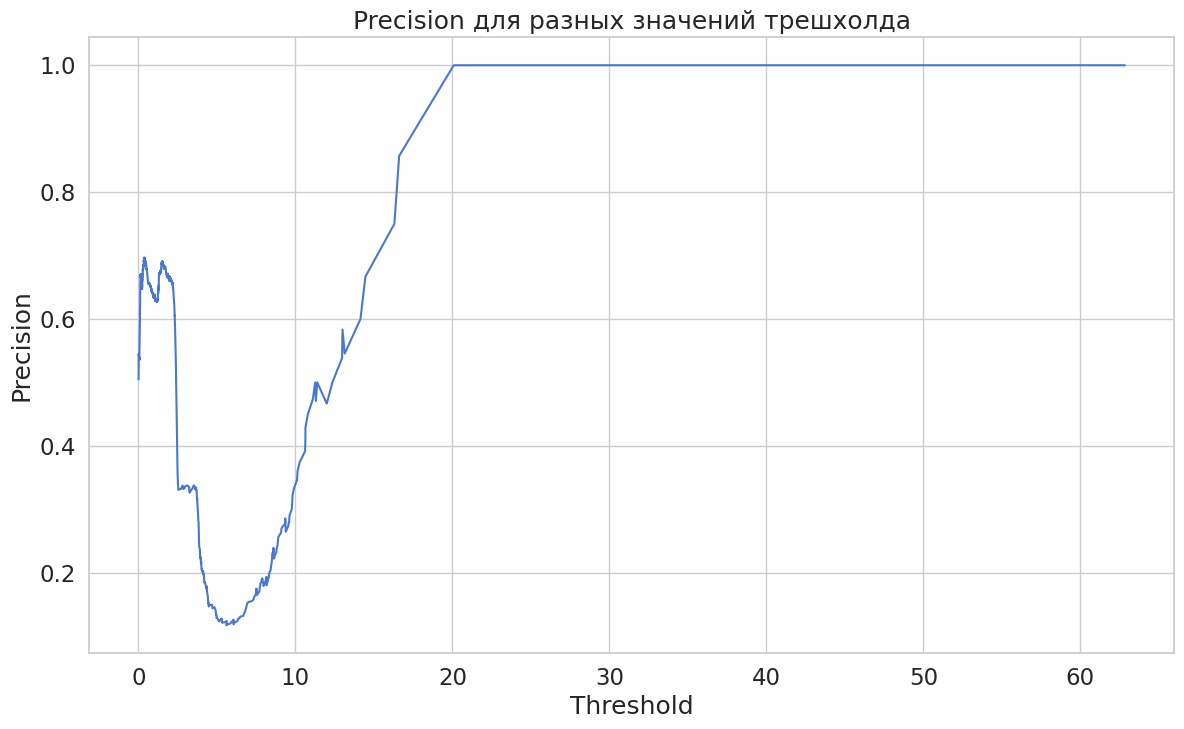

In [184]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


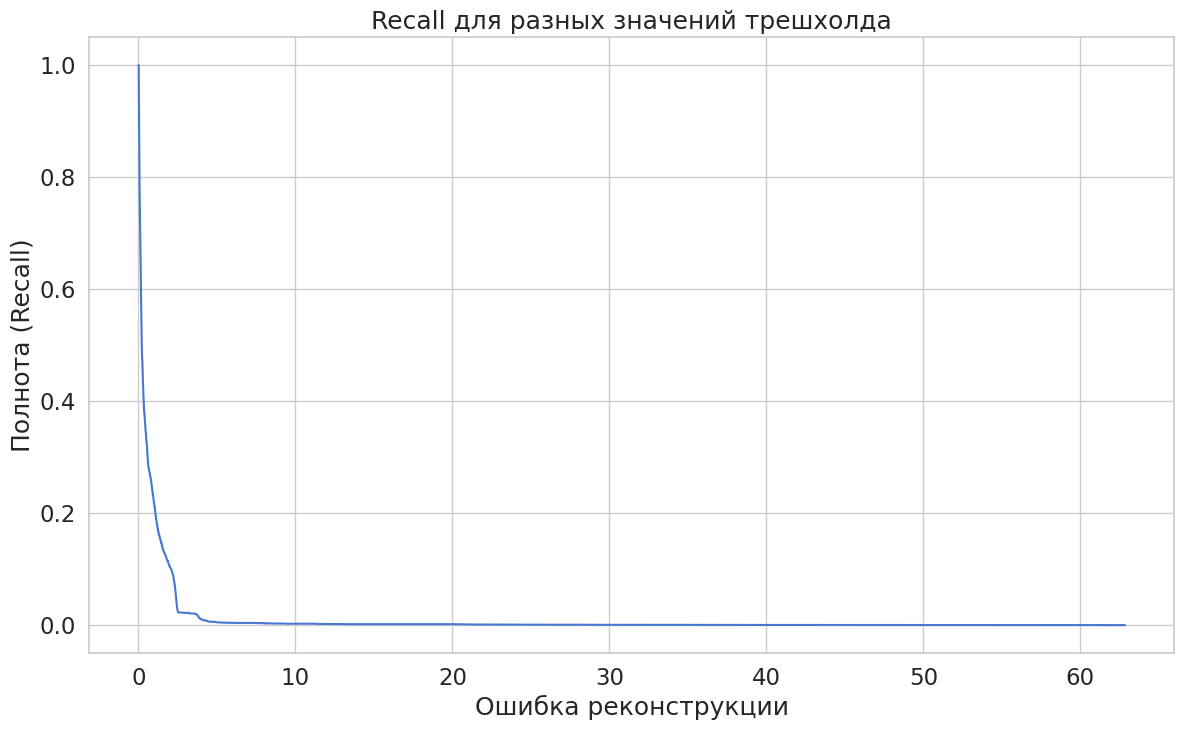

In [185]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, является ли новая/невидимая транзакция нормальной или мошеннической, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает предопределенный порог, мы помечаем ее как мошенничество (поскольку наша модель должна иметь низкую ошибку при обычных транзакциях). Давайте выберем это значение:

In [192]:
threshold = 1.4

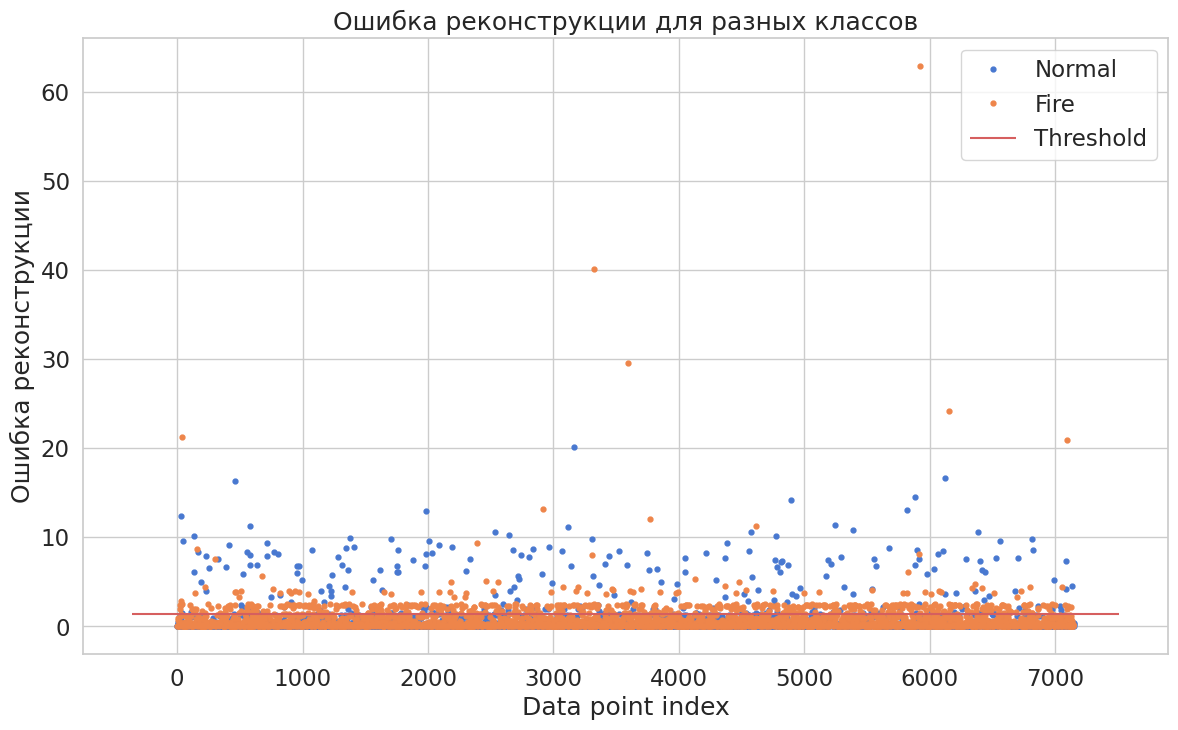

In [193]:
groups = reconstructionErrorDF.groupby('Fire Alarm')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Fire" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-194-a4878850c632>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


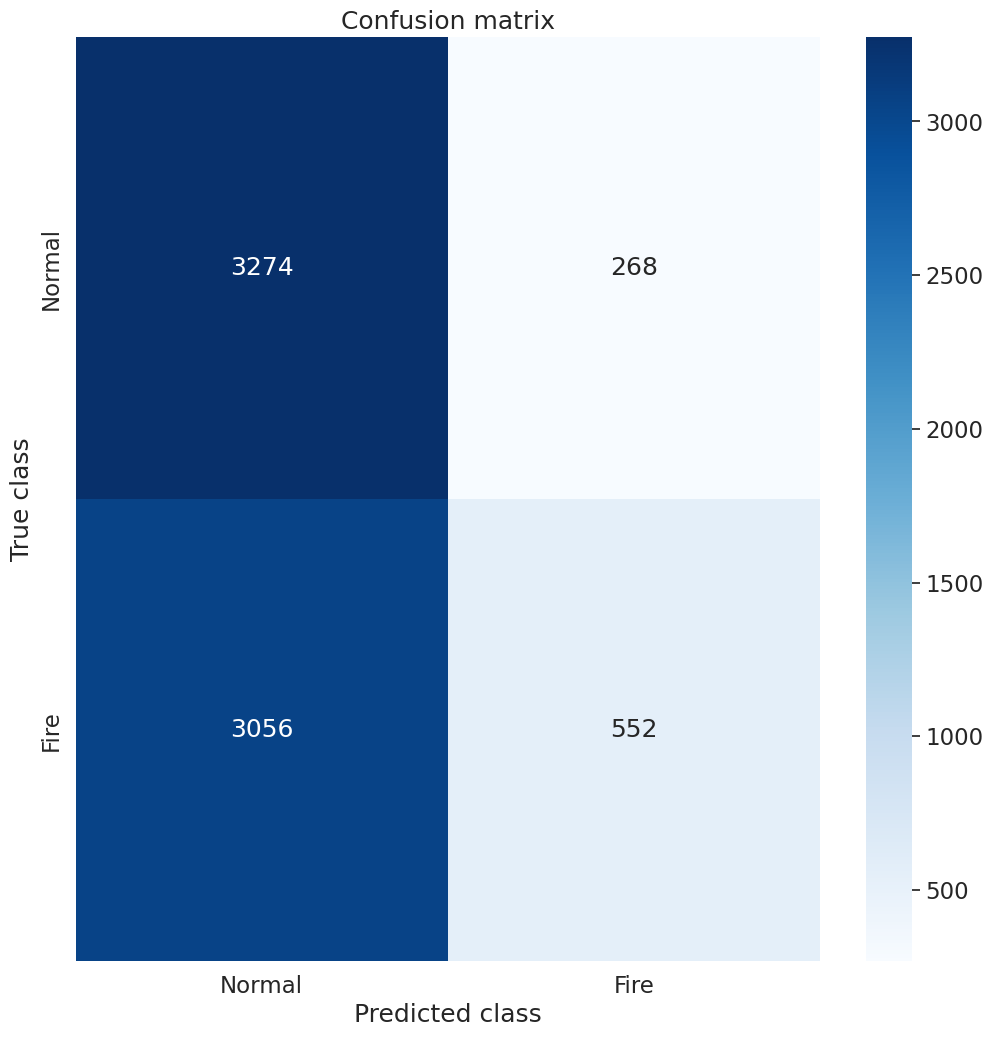

In [194]:

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF['Fire Alarm'], y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Наша модель, похоже, выявляет множество случаев мошенничества. Но количество обычных транзакций, классифицируемых как мошенничество, действительно велико. Можно настроить порог здесь и там, чтобы получить лучшие результаты.

## Выводы


Мы создали очень простой Deep Autoencoder в PyTorch, который может реконструировать, как выглядят немошеннические транзакции. Он научился распознавать немошеннические транзакции, изучая некоторые шаблоны, присутствующие в этих транзакциях, и что это за шаблоны, о которых трудно сказать — загадка любой нейронной сети с глубоким обучением.

PyTorch предоставил нам очень понятный и простой в использовании API для создания нетривиального Deep Autoencoder. Можно попытаться создать аналогичный автоэнкодер, используя другую структуру, например Tensorflow/Keras/fast.ai, для другого домена/проблемы, например, классифицировать изображения как содержащие неприемлемый контент.